In [1]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from hypopt import GridSearch

In [2]:
model_path = "/neurospin/dico/jchavas/Runs/70_self-supervised_two-regions/Output/2024-05-07/17-26-21_154"
ukb_emb_file = f"{model_path}/ukb_embeddings/full_embeddings.csv"
schiz_emb_file = f"{model_path}/schiz_embeddings/full_embeddings.csv"
schiz_path = "/neurospin/dico/data/deep_folding/current/datasets/schiz/aymeric_stratification/with_sub"
schiz_label_file = f"{schiz_path}/used_schiz_subjects.csv"
train_file = f"{schiz_path}/train_subjects.csv"
val_file = f"{schiz_path}/val_subjects.csv"
test_intra_file = f"{schiz_path}/test_intra_subjects.csv"
test_file = f"{schiz_path}/test_subjects.csv"

In [3]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-2.868891,-0.368058,-1.639071,-2.702636,24.760350,328.251430,-6.155386,-4.852545,99.105545,-3.770058,...,196.726580,-8.370437,481.835630,393.393340,89.449700,635.032000,325.938050,70.105156,-0.378246,483.235400
sub-1000458,350.711150,617.962900,-0.825832,596.073800,529.344000,1022.099100,823.217470,-2.054950,499.170230,-8.092382,...,-1.643544,-0.960263,-5.636589,469.697940,-0.945099,-4.329172,-7.507878,1066.472900,-2.173929,263.600700
sub-1000575,-1.104033,-1.135052,197.595890,-1.355339,-1.100050,248.516080,106.344150,-2.823939,-0.934918,-1.918464,...,-2.010498,-5.832932,22.096544,756.573000,59.482470,461.017800,530.015870,-1.566568,-1.512872,-0.042711
sub-1000606,495.236240,418.357300,-3.859657,-3.189036,-0.870604,-1.511794,955.534900,-4.644189,227.792850,-9.538205,...,-5.546790,-2.642187,-1.296834,6.311005,-1.075276,-3.946515,-2.080509,-1.802815,-2.851882,-3.384521
sub-1000963,-0.056359,-4.783603,-2.625467,-2.323882,-0.663136,-1.010007,-5.149221,-5.310495,328.255980,551.753360,...,-4.675682,-2.282285,28.887999,-3.652923,-3.460225,668.517400,1018.194400,-9.200782,-5.979842,-4.713279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,-3.009088,-5.747623,11.596108,-1.390614,-4.433293,-1.640884,-0.769012,178.704540,-4.444595,-2.204452,...,-1.903193,-7.743419,149.730160,354.984220,156.440540,599.004200,829.532400,-6.547669,138.618070,-3.003732
sub-6023808,472.054800,-0.323073,194.695340,-1.420399,237.451390,246.436900,-3.683970,-4.143352,91.998930,892.884400,...,-1.379239,-1.633720,1.292973,321.070370,266.444760,226.789580,1149.253200,-4.308256,-1.946643,84.841380
sub-6023847,339.040040,-1.187755,-5.104610,-0.675336,-3.489315,-3.171868,1075.686500,-0.940386,-0.648224,-10.649032,...,-5.900459,-1.483151,-6.001945,-4.548874,-1.909666,-4.589243,-3.878112,-2.582579,-0.476821,-7.649068


In [4]:
schiz_emb = pd.read_csv(schiz_emb_file, index_col=0)
schiz_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-10171_ses-1,190.145750,591.636000,199.404570,-4.523598,36.960587,97.324104,226.370240,-4.657064,-1.981488,-3.837263,...,-0.876668,-7.703198,139.992360,814.702760,200.446430,-1.288402,254.812580,68.716220,171.405610,497.007750
sub-10189_ses-1,-1.245837,227.243550,-0.120218,1.917290,151.836650,472.173300,205.983720,-3.708599,403.392120,-7.383984,...,-1.523401,-4.828810,204.796100,680.015870,-0.842443,288.134950,-1.253865,333.548200,-3.618395,101.767680
sub-10193_ses-1,425.621640,188.890580,302.519260,-4.154293,75.737050,-0.047185,-0.557415,-4.917359,116.672390,762.159000,...,-5.070346,-2.820193,91.042860,552.981800,163.960650,170.079100,1177.217000,-7.414849,-5.611752,-1.510364
sub-10206_ses-1,-2.970782,196.487990,-2.127649,-3.007309,-0.470139,369.371830,-3.211348,-4.794978,56.556915,-10.419801,...,242.519700,-9.541921,438.733580,665.728500,50.925896,503.892300,-2.355926,494.295000,-0.141044,637.030150
sub-10217_ses-1,415.718870,47.379070,-1.318816,-1.824142,-0.909490,-0.825218,540.266500,-3.598820,-1.293689,-1.414086,...,-5.563665,-3.727009,-4.658706,10.248703,-0.764172,-1.905268,415.588350,-5.278369,-1.820906,-3.648683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-st110288_ses-v1,258.277130,-4.179158,-2.378782,545.011300,174.403370,404.175350,180.323120,-1.518537,386.294740,255.977430,...,-4.442514,291.160500,-5.576770,-2.969358,-4.004993,310.595250,482.134920,-3.236782,-3.837237,-5.001811
sub-va110289_ses-v1,-4.912154,-8.405313,-0.746276,-2.842805,-5.297034,-3.188452,-6.594659,1.224932,-4.354639,182.104740,...,-1.345838,-7.855120,326.419370,165.636580,-0.837667,1110.219800,1272.430300,-10.160613,71.859980,-2.233282
sub-ye110322_ses-v1,68.109430,51.613060,-0.317894,-2.471679,-0.050489,115.034670,75.014400,-4.397651,288.724880,-0.645986,...,-3.893072,-3.913745,211.599010,301.870420,10.271661,279.826630,549.453400,-4.094875,-4.681827,-1.940203


In [5]:
schiz_label = pd.read_csv(schiz_label_file, index_col=0)
schiz_label

,sex,age,diagnosis,study,site
participant_id,,,,,
sub-INV07WT2ZL3,M,29.0,control,BSNIP,Dallas
sub-INV0AL14J6U,M,43.0,schizophrenia,BSNIP,Dallas
sub-INV14XK7P6E,M,30.0,control,BSNIP,Dallas
sub-INV1HXNTXYF,F,18.0,control,BSNIP,Dallas
sub-INV1XCNF4J5,F,25.0,control,BSNIP,Dallas
...,...,...,...,...,...
sub-ESOC10060_ses-v1,F,26.0,control,PRAGUE,PRAGUE
sub-ESOC10019_ses-v1,F,28.0,control,PRAGUE,PRAGUE
sub-ESOC10063_ses-v1,M,31.0,control,PRAGUE,PRAGUE


In [6]:
schiz_train = pd.read_csv(train_file, header=None)
schiz_val = pd.read_csv(val_file, header=None)
schiz_test_intra = pd.read_csv(test_intra_file, header=None)
schiz_test = pd.read_csv(test_file, header=None)
schiz_train

,0
0,sub-ESOC10104_ses-v1
1,sub-NM2020_ses-v1
2,sub-or130001_ses-v1
3,sub-ESOC10112_ses-v1
4,sub-CC6287_ses-v1
...,...
908,sub-HC027_ses-1
909,sub-HC010_ses-1
910,sub-SS086_ses-1
911,sub-HC023_ses-1


In [7]:
np.unique(schiz_label.diagnosis)

array(['control', 'schizophrenia'], dtype=object)

# UKBioBank

In [8]:
norm = ukb_emb.apply(np.linalg.norm, axis=1)
ukb_emb = ukb_emb.div(norm, axis=0)

In [9]:
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-0.000739,-0.000095,-0.000422,-0.000696,0.006377,0.084542,-0.001585,-0.001250,0.025525,-9.709911e-04,...,0.050668,-0.002156,0.124098,0.101320,0.023038,0.163555,0.083946,0.018056,-0.000097,0.124459
sub-1000458,0.056852,0.100175,-0.000134,0.096627,0.085810,0.165688,0.133448,-0.000333,0.080918,-1.311822e-03,...,-0.000266,-0.000156,-0.000914,0.076141,-0.000153,-0.000702,-0.001217,0.172881,-0.000352,0.042731
sub-1000575,-0.000347,-0.000357,0.062086,-0.000426,-0.000346,0.078086,0.033414,-0.000887,-0.000294,-6.027991e-04,...,-0.000632,-0.001833,0.006943,0.237722,0.018690,0.144856,0.166536,-0.000492,-0.000475,-0.000013
sub-1000606,0.119092,0.100605,-0.000928,-0.000767,-0.000209,-0.000364,0.229783,-0.001117,0.054779,-2.293702e-03,...,-0.001334,-0.000635,-0.000312,0.001518,-0.000259,-0.000949,-0.000500,-0.000434,-0.000686,-0.000814
sub-1000963,-0.000015,-0.001310,-0.000719,-0.000637,-0.000182,-0.000277,-0.001410,-0.001455,0.089916,1.511371e-01,...,-0.001281,-0.000625,0.007913,-0.001001,-0.000948,0.183121,0.278905,-0.002520,-0.001638,-0.001291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,-0.000725,-0.001385,0.002795,-0.000335,-0.001069,-0.000396,-0.000185,0.043077,-0.001071,-5.313830e-04,...,-0.000459,-0.001867,0.036092,0.085569,0.037710,0.144390,0.199959,-0.001578,0.033414,-0.000724
sub-6023808,0.119385,-0.000082,0.049239,-0.000359,0.060052,0.062325,-0.000932,-0.001048,0.023267,2.258140e-01,...,-0.000349,-0.000413,0.000327,0.081200,0.067385,0.057356,0.290651,-0.001090,-0.000492,0.021457
sub-6023847,0.068396,-0.000240,-0.001030,-0.000136,-0.000704,-0.000640,0.217001,-0.000190,-0.000131,-2.148261e-03,...,-0.001190,-0.000299,-0.001211,-0.000918,-0.000385,-0.000926,-0.000782,-0.000521,-0.000096,-0.001543


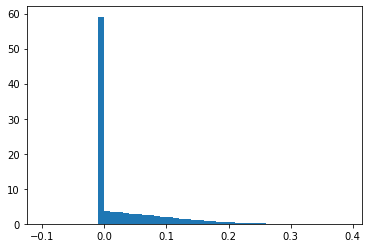

In [10]:
p = plt.hist(ukb_emb.values.ravel(), bins=np.arange(-0.1,0.4,0.01), density=True)

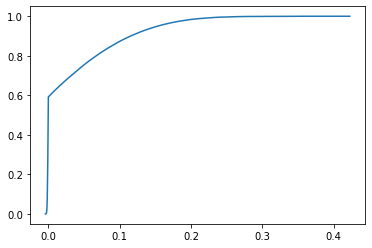

In [11]:
Z = ukb_emb.values.ravel()
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

plt.plot(X2, F2)

In [12]:
X2[int(N*0.59)]

-2.1919540569670475e-06

In [13]:
len(ukb_emb)

21051

In [14]:
ukb_positive = (ukb_emb>0).sum(axis=0)/len(ukb_emb)
ukb_positive = ukb_positive.sort_values(ascending=False)

In [15]:
ukb_positive

dim83     0.985986
dim26     0.961665
dim113    0.951736
dim22     0.943661
dim65     0.875113
            ...   
dim73     0.000000
dim155    0.000000
dim104    0.000000
dim173    0.000000
dim188    0.000000
Length: 256, dtype: float64

In [16]:
ukb_positive[10:50]

dim91     0.825899
dim48     0.822859
dim66     0.807610
dim93     0.799249
dim253    0.793454
dim180    0.778538
dim111    0.777825
dim252    0.770415
dim98     0.767992
dim41     0.763194
dim206    0.759299
dim196    0.756971
dim33     0.756211
dim238    0.751271
dim237    0.743433
dim220    0.739110
dim39     0.738825
dim14     0.738635
dim96     0.734359
dim177    0.725904
dim50     0.719586
dim88     0.717971
dim70     0.715453
dim208    0.713363
dim74     0.711795
dim82     0.690799
dim17     0.686476
dim217    0.680538
dim58     0.676690
dim28     0.672462
dim186    0.669849
dim232    0.664101
dim32     0.663674
dim76     0.662914
dim68     0.660444
dim110    0.651275
dim163    0.650895
dim85     0.649518
dim149    0.647570
dim78     0.638782
dtype: float64

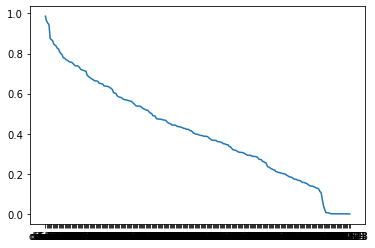

In [17]:
plt.plot(ukb_positive)

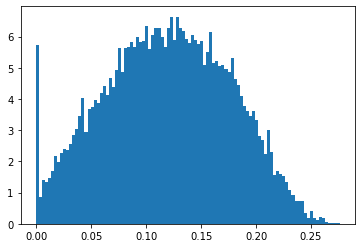

In [18]:
p = plt.hist(ukb_emb.loc[:,"dim83"], bins=100, density=True)

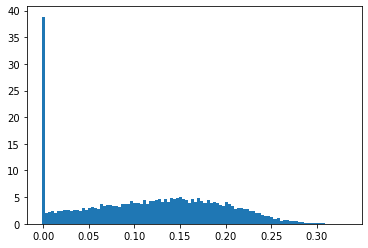

In [19]:
p = plt.hist(ukb_emb.loc[:,"dim65"], bins=100, density=True)

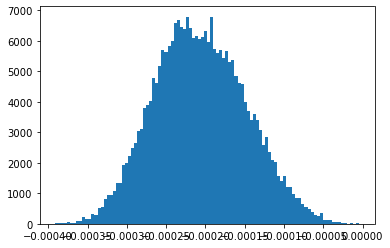

In [20]:
p = plt.hist(ukb_emb.loc[:,"dim188"], bins=100, density=True)

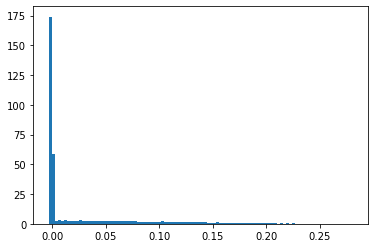

In [21]:
p = plt.hist(ukb_emb.loc[:,"dim10"], bins=100, density=True)

# Schizophrene

In [22]:
norm = schiz_emb.apply(np.linalg.norm, axis=1)
schiz_emb = schiz_emb.div(norm, axis=0)

In [23]:
def compute_umap(df, n_neighbors=15):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [24]:
# visual_ukb_emb, reducer = compute_umap(ukb_emb, n_neighbors=15)

In [25]:
# plt.scatter(visual_ukb_emb[:,0], visual_ukb_emb[:,1], c='black', s=1, alpha=0.6)

In [26]:
# visual_schiz_emb = reducer.transform(schiz_emb)

In [27]:
# plt.scatter(visual_ukb_emb[:,0], visual_ukb_emb[:,1], c='black', s=1, alpha=0.6)
# plt.scatter(visual_schiz_emb[:,0], visual_schiz_emb[:,1], c='red', s=20, alpha=1)

In [28]:
ukb_positive = (ukb_emb>0).sum(axis=0)/len(ukb_emb)

In [29]:
schiz_order = schiz_emb.copy()
schiz_order.loc["ukb_positive",:] = ukb_positive
schiz_order

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-10171_ses-1,0.039733,0.123630,0.041668,-0.000945,0.007723,0.020337,0.047303,-0.000973,-0.000414,-0.000802,...,-0.000183,-0.001610,0.029253,0.170243,0.041886,-0.000269,0.053246,0.014359,0.035817,0.103856
sub-10189_ses-1,-0.000320,0.058452,-0.000031,0.000493,0.039056,0.121454,0.052984,-0.000954,0.103762,-0.001899,...,-0.000392,-0.001242,0.052678,0.174916,-0.000217,0.074115,-0.000323,0.085797,-0.000931,0.026177
sub-10193_ses-1,0.102812,0.045628,0.073076,-0.001004,0.018295,-0.000011,-0.000135,-0.001188,0.028183,0.184106,...,-0.001225,-0.000681,0.021992,0.133577,0.039606,0.041084,0.284366,-0.001791,-0.001356,-0.000365
sub-10206_ses-1,-0.000591,0.039114,-0.000424,-0.000599,-0.000094,0.073529,-0.000639,-0.000955,0.011258,-0.002074,...,0.048277,-0.001899,0.087336,0.132523,0.010138,0.100307,-0.000469,0.098397,-0.000028,0.126810
sub-10217_ses-1,0.119747,0.013647,-0.000380,-0.000525,-0.000262,-0.000238,0.155623,-0.001037,-0.000373,-0.000407,...,-0.001603,-0.001074,-0.001342,0.002952,-0.000220,-0.000549,0.119709,-0.001520,-0.000525,-0.001051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-va110289_ses-v1,-0.001150,-0.001967,-0.000175,-0.000665,-0.001240,-0.000746,-0.001543,0.000287,-0.001019,0.042616,...,-0.000315,-0.001838,0.076388,0.038762,-0.000196,0.259813,0.297773,-0.002378,0.016817,-0.000523
sub-ye110322_ses-v1,0.022204,0.016826,-0.000104,-0.000806,-0.000016,0.037501,0.024455,-0.001434,0.094124,-0.000211,...,-0.001269,-0.001276,0.068981,0.098410,0.003349,0.091223,0.179122,-0.001335,-0.001526,-0.000633
sub-yh100442_ses-v1,0.066291,-0.000212,-0.000559,0.008395,0.069917,0.114847,-0.001855,-0.000875,0.066148,0.078897,...,0.071893,-0.000545,0.093137,0.046846,0.049478,0.148516,0.190105,0.009388,0.000765,0.118852


In [30]:
schiz_order = schiz_order.sort_values(schiz_order.last_valid_index(), ascending=False, axis=1)

In [31]:
schiz_order

,dim83,dim26,dim113,dim22,dim65,dim81,dim127,dim239,dim121,dim23,...,dim51,dim35,dim18,dim144,dim72,dim73,dim155,dim104,dim173,dim188
ID,,,,,,,,,,,,,,,,,,,,,
sub-10171_ses-1,0.192350,0.148627,0.096185,0.201360,0.108362,0.040426,0.086486,-0.000238,0.034632,0.006636,...,-0.000205,-0.000112,-0.000104,-0.000069,-0.000152,-0.000084,-0.000094,-0.000196,-0.000116,-0.000168
sub-10189_ses-1,0.186983,0.190931,0.083097,0.138926,0.266221,0.080255,0.234423,0.027957,0.195326,0.080230,...,-0.000236,-0.000204,-0.000143,-0.000091,-0.000195,-0.000082,-0.000151,-0.000185,-0.000174,-0.000238
sub-10193_ses-1,0.122138,-0.000314,0.223875,0.067560,0.083830,0.113426,-0.000628,0.158637,0.035913,-0.000407,...,-0.000221,-0.000115,-0.000183,-0.000111,-0.000253,-0.000122,-0.000148,-0.000261,-0.000172,-0.000135
sub-10206_ses-1,0.213287,0.205676,0.009380,0.102690,0.143675,0.067212,0.261287,-0.000585,0.105514,-0.000036,...,-0.000178,-0.000125,-0.000036,-0.000048,-0.000108,-0.000032,-0.000090,-0.000067,-0.000099,-0.000225
sub-10217_ses-1,0.104955,0.179516,0.140207,0.195995,0.135064,0.052690,0.040512,0.161858,0.028072,0.173588,...,-0.000206,-0.000213,-0.000194,-0.000146,-0.000212,-0.000181,-0.000178,-0.000393,-0.000177,-0.000255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-va110289_ses-v1,0.102826,0.026773,0.164652,0.036174,0.023463,0.118066,0.085593,0.245487,0.151022,0.096853,...,-0.000181,-0.000139,-0.000115,-0.000087,-0.000212,-0.000110,-0.000161,-0.000236,-0.000101,-0.000179
sub-ye110322_ses-v1,0.197132,0.132946,0.181469,0.176142,0.190669,0.108513,0.109556,0.224338,0.193405,0.088635,...,-0.000326,-0.000242,-0.000250,-0.000156,-0.000288,-0.000155,-0.000221,-0.000377,-0.000251,-0.000278
sub-yh100442_ses-v1,0.161913,0.094197,0.138080,0.065753,0.048400,0.109420,0.075088,0.040519,-0.000337,-0.000940,...,-0.000156,-0.000117,-0.000071,-0.000029,-0.000178,-0.000093,-0.000125,-0.000137,-0.000099,-0.000220


# Fit on schiz datasets

In [32]:
schiz_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-10171_ses-1,0.039733,0.123630,0.041668,-0.000945,0.007723,0.020337,0.047303,-0.000973,-0.000414,-0.000802,...,-0.000183,-0.001610,0.029253,0.170243,0.041886,-0.000269,0.053246,0.014359,0.035817,0.103856
sub-10189_ses-1,-0.000320,0.058452,-0.000031,0.000493,0.039056,0.121454,0.052984,-0.000954,0.103762,-0.001899,...,-0.000392,-0.001242,0.052678,0.174916,-0.000217,0.074115,-0.000323,0.085797,-0.000931,0.026177
sub-10193_ses-1,0.102812,0.045628,0.073076,-0.001004,0.018295,-0.000011,-0.000135,-0.001188,0.028183,0.184106,...,-0.001225,-0.000681,0.021992,0.133577,0.039606,0.041084,0.284366,-0.001791,-0.001356,-0.000365
sub-10206_ses-1,-0.000591,0.039114,-0.000424,-0.000599,-0.000094,0.073529,-0.000639,-0.000955,0.011258,-0.002074,...,0.048277,-0.001899,0.087336,0.132523,0.010138,0.100307,-0.000469,0.098397,-0.000028,0.126810
sub-10217_ses-1,0.119747,0.013647,-0.000380,-0.000525,-0.000262,-0.000238,0.155623,-0.001037,-0.000373,-0.000407,...,-0.001603,-0.001074,-0.001342,0.002952,-0.000220,-0.000549,0.119709,-0.001520,-0.000525,-0.001051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-st110288_ses-v1,0.070960,-0.001148,-0.000654,0.149738,0.047916,0.111045,0.049543,-0.000417,0.106132,0.070328,...,-0.001221,0.079995,-0.001532,-0.000816,-0.001100,0.085334,0.132464,-0.000889,-0.001054,-0.001374
sub-va110289_ses-v1,-0.001150,-0.001967,-0.000175,-0.000665,-0.001240,-0.000746,-0.001543,0.000287,-0.001019,0.042616,...,-0.000315,-0.001838,0.076388,0.038762,-0.000196,0.259813,0.297773,-0.002378,0.016817,-0.000523
sub-ye110322_ses-v1,0.022204,0.016826,-0.000104,-0.000806,-0.000016,0.037501,0.024455,-0.001434,0.094124,-0.000211,...,-0.001269,-0.001276,0.068981,0.098410,0.003349,0.091223,0.179122,-0.001335,-0.001526,-0.000633


In [33]:
schiz_all = pd.merge(schiz_label, schiz_emb, left_index=True, right_index=True)

In [54]:
# schiz_all = schiz_all[schiz_all['sex'] == 'M']

In [55]:
d = {'control': 0, "schizophrenia": 1}
train = schiz_all.loc[schiz_all.index.isin(schiz_train[0]),:]
y_train = train['diagnosis'].map(d)
X_train = train.iloc[:, 5:]
val = schiz_all.loc[schiz_all.index.isin(schiz_val[0]),:]
y_val = val['diagnosis'].map(d)
X_val = val.iloc[:, 5:]
test_intra = schiz_all.loc[schiz_all.index.isin(schiz_test_intra[0]),:]
y_test_intra = test_intra['diagnosis'].map(d)
X_test_intra = test_intra.iloc[:, 5:]
test = schiz_all.loc[schiz_all.index.isin(schiz_test[0]),:]
y_test = test['diagnosis'].map(d)
X_test = test.iloc[:, 5:]

In [56]:
X_train.shape

(503, 256)

In [57]:
bst = XGBClassifier(max_depth=1, min_child_weight=5, alpha=1, learning_rate=0.001, objective='binary:logistic')

In [58]:
X_train.shape

(503, 256)

In [59]:
y_train.shape

(503,)

In [60]:
bst.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [61]:
roc_auc_score(y_train, bst.predict_proba(X_train)[:,1])

0.6241343326060147

In [62]:
roc_auc_score(y_val, bst.predict_proba(X_val)[:,1])

0.5144927536231884

In [63]:
roc_auc_score(y_test_intra, bst.predict_proba(X_test_intra)[:,1])

0.5907608695652173

In [64]:
roc_auc_score(y_test, bst.predict_proba(X_test)[:,1])

0.4902973790322581

In [74]:
param_grid = {
    'max_depth': [1],
    'learning_rate': [0.0001, 0.001],
    'subsample': [0.2]
}

In [75]:
split_index = [-1]*len(X_train) + [0]*len(X_val)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

In [76]:
X.shape

(559, 256)

In [77]:
# Grid-search all parameter combinations using a validation set.
opt = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic'), cv=pds, param_grid = param_grid)
opt.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
          

In [78]:
roc_auc_score(y_train, opt.best_estimator_.predict_proba(X_train)[:,1])

0.6594092907061315

In [79]:
roc_auc_score(y_val, opt.best_estimator_.predict_proba(X_val)[:,1])

0.6772068511198945

In [80]:
roc_auc_score(y_test_intra, opt.best_estimator_.predict_proba(X_test_intra)[:,1])

0.6728260869565217

In [81]:
roc_auc_score(y_test, opt.best_estimator_.predict_proba(X_test)[:,1])

0.5138608870967742

In [82]:
opt.best_params_

{'learning_rate': 0.001, 'max_depth': 1, 'subsample': 0.2}